In [3]:
#Import dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
get_ipython().run_line_magic('matplotlib', 'inline')
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')
import datetime
import quandl
# from plotline import *

In [4]:
# Read csv file
df = pd.read_csv("all_df.csv")
df

,Unnamed: 0,Date,Consumption,Crude Oil Imports,Crude Oil Exports(1000 Barrels),Crude Oil Production (1000 Barrels),US Population,Consumption Change,Consumption Change (Y/N)
0,0,Sep-73,5377.0,3471.0,160,271959,212289.0,NaN,0
1,1,Oct-73,5765.0,3739.0,0,285940,212475.0,388.0,1
2,2,Nov-73,6088.0,3452.0,0,274829,212634.0,323.0,1
3,3,Dec-73,6389.0,2891.0,177,280960,212785.0,301.0,1
4,4,Jan-74,6378.0,2382.0,534,276950,212932.0,-11.0,0
...,...,...,...,...,...,...,...,...,...
551,551,Aug-19,6863.0,6944.0,85406,385168,329591.0,39.0,1
552,552,Sep-19,6275.0,6483.0,92780,374856,329786.0,-588.0,0
553,553,Oct-19,6370.0,6242.0,105770,392849,329982.0,95.0,1
554,554,Nov-19,6778.0,5818.0,92408,385793,330155.0,408.0,1


In [5]:
#Creating just consumption dataframe
new_df = df[['Date','Consumption']]
new_df['Date'] = pd.to_datetime(new_df['Date'], format='%b-%y')
new_df = new_df.set_index("Date")
new_df

,Consumption
Date,
1973-09-01,5377.0
1973-10-01,5765.0
1973-11-01,6088.0
1973-12-01,6389.0
1974-01-01,6378.0
...,...
2019-08-01,6863.0
2019-09-01,6275.0
2019-10-01,6370.0


In [6]:
#Checking for null values
new_df.isnull().values.any()

False

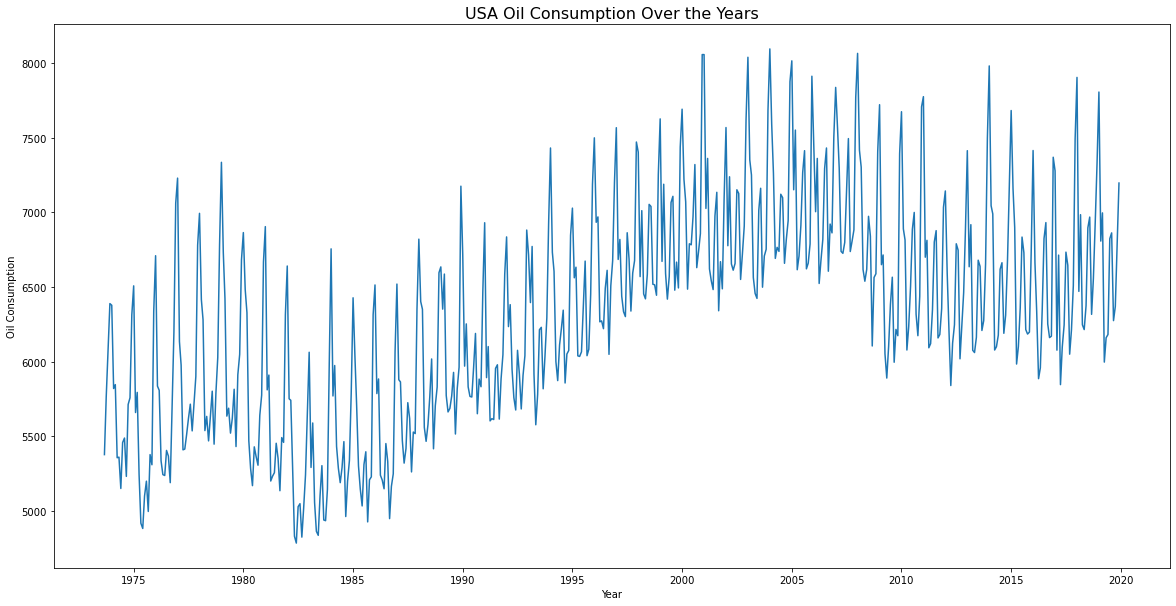

In [7]:
#Inspect the graph to see timeseries data 
plt.figure(figsize=(20, 10))
ax = plt.axes()
fig = plt.plot(new_df)
ax.set_xlabel('Year')
ax.set_ylabel('Oil Consumption')
plt.title('USA Oil Consumption Over the Years', fontsize=16)
plt.show()

## Determine Whether Time Series Data are Stationary

The time series is stationary if the means and SD remain constant with time
Step 2b: Test for Stationarity in the time series data using the Dickey-Fuller Test.
If the p-value for this test is > .05 on the test, we accept the null hypothesis and conclude the time series is not stationary.
If the p-value for this test is <= .05, we reject the null hypothesis and conclude the time series is stationary.
If the ADF Statistic is much lower than the critical values, that also confirms the time series is stationary.¶

In [8]:
def test_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.rcParams["figure.figsize"] = [18,10]
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

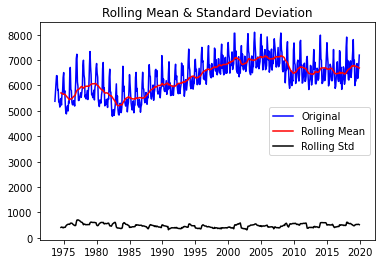

Results of Dickey-Fuller Test:
ADF Statistic: -1.55950901284851
p-value: 0.5038949651468432
Critical Values:
	1%: -3.442495284887805
	5%: -2.86689723299801
	10%: -2.5696232204003677


In [9]:
# Stationarity Test
test_stationarity(new_df)

P-value is greater than 0.5, thus timeseries data is not stationary.

## Making Time Series Stationary
### Transforming  and Eliminating Data by Differencing
One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity. One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. 

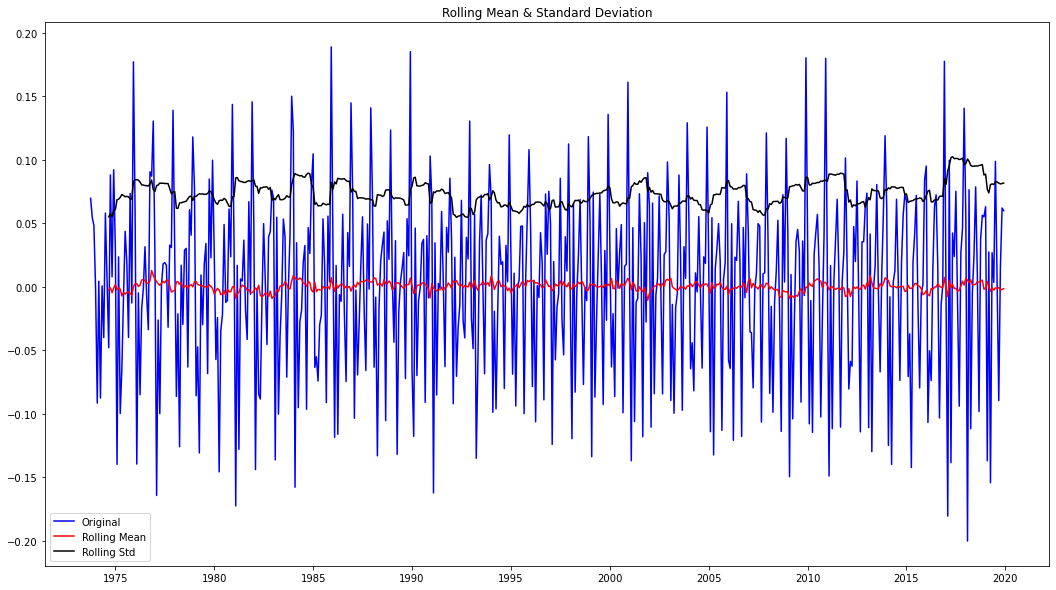

Results of Dickey-Fuller Test:
ADF Statistic: -6.727284936972895
p-value: 3.3645900463053274e-09
Critical Values:
	1%: -3.442495284887805
	5%: -2.86689723299801
	10%: -2.5696232204003677


In [10]:
new_log= np.log(new_df)
new_log_diff = new_log - new_log.shift()
new_log_diff.dropna(inplace=True)
test_stationarity(new_log_diff)

#### Now, with transformation, timeseries data are stationary because p-value is much less than 0.05

## Decomposition: removing trend and seasonality

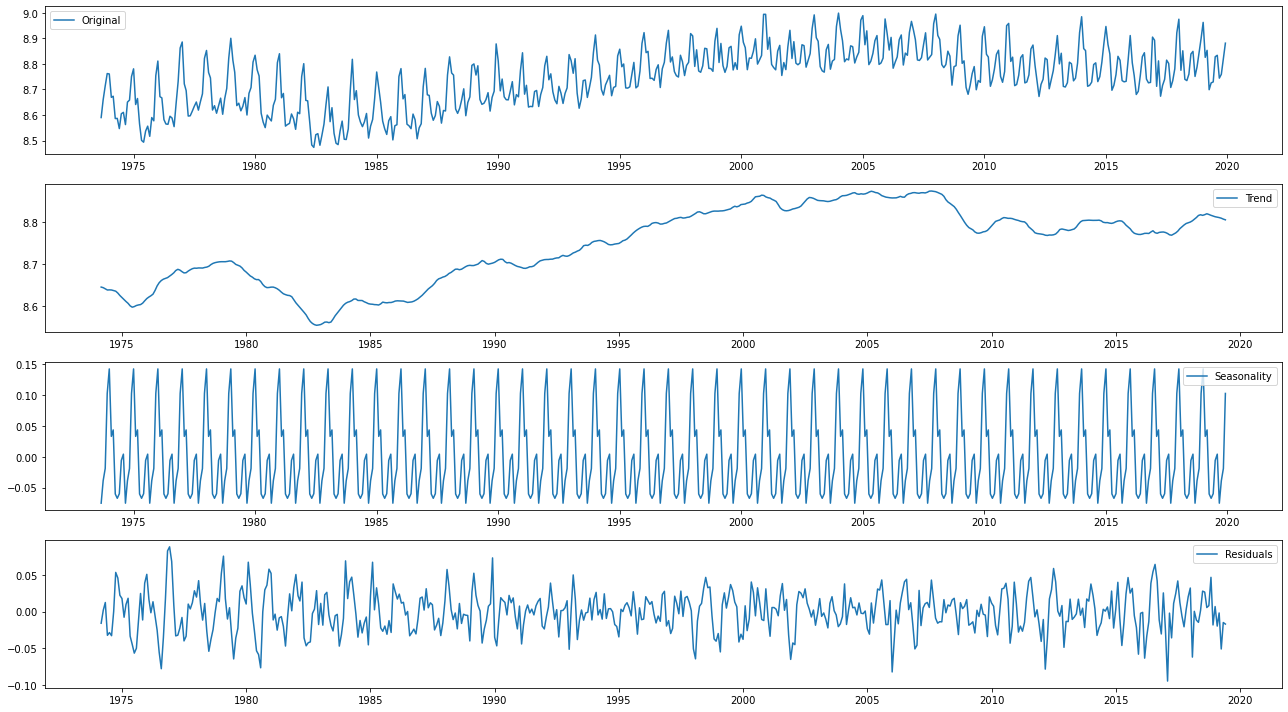

In [11]:
## Modeling both trend and seasonality and removing them from model
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(new_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(new_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Checking residuals closer when sesonality and trend are separated

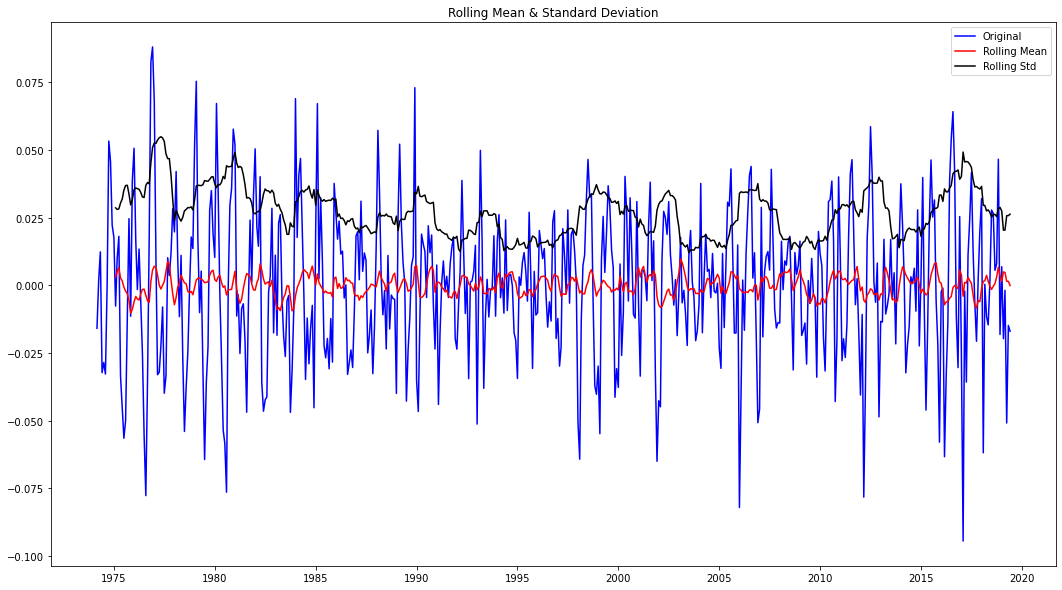

Results of Dickey-Fuller Test:
ADF Statistic: -15.4957908441435
p-value: 2.4515435460707524e-28
Critical Values:
	1%: -3.4426552678216003
	5%: -2.8669676577777548
	10%: -2.569660749624767


In [12]:
#Checking stationarity of residuals
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Step 3: Explore Autocorrelation Functioms (ACF) and Partial Autocorrelation Functions (PACF)
ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.
PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.
An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


In [13]:
lag_acf = acf(new_log_diff, nlags=20)
lag_pacf = pacf(new_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

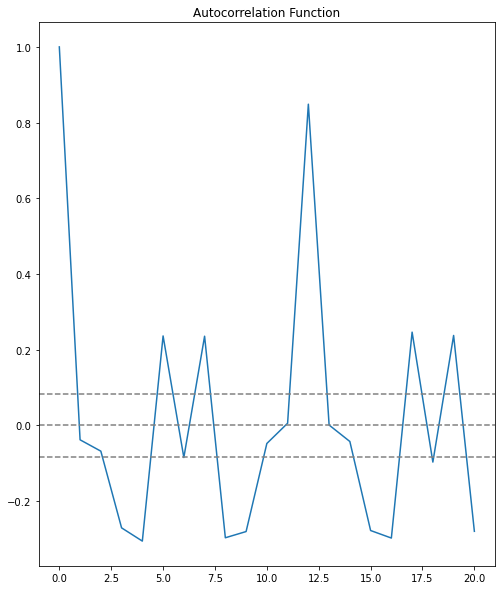

In [14]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

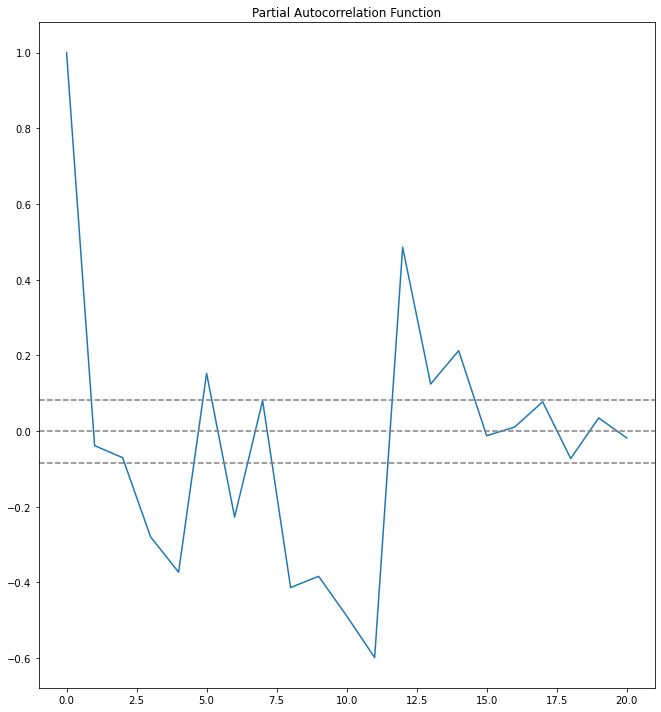

In [15]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.2.
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.2.

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

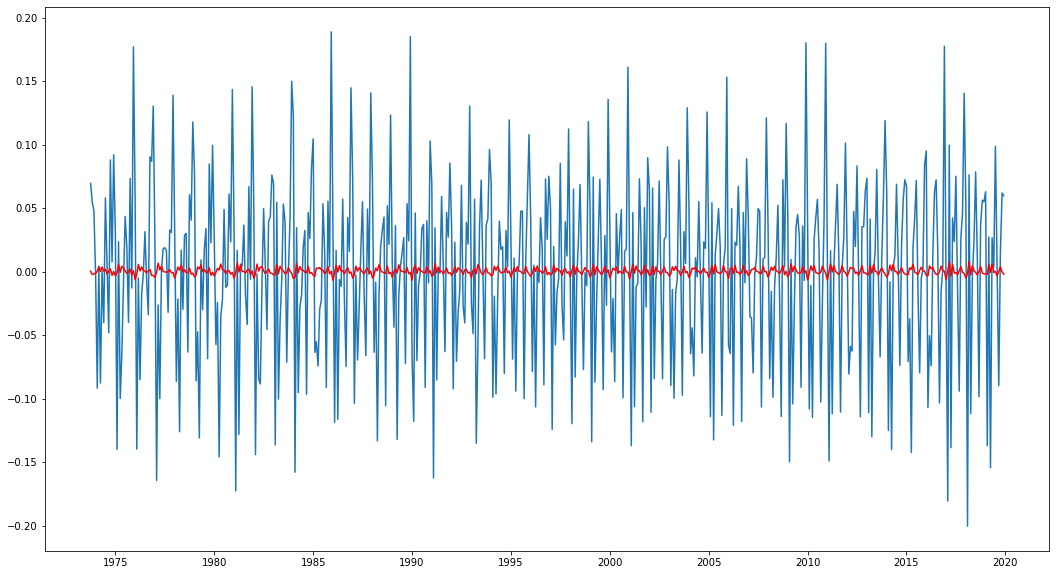

In [16]:
#AR Model
model = ARIMA(new_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(new_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-new_log_diff)**2))

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

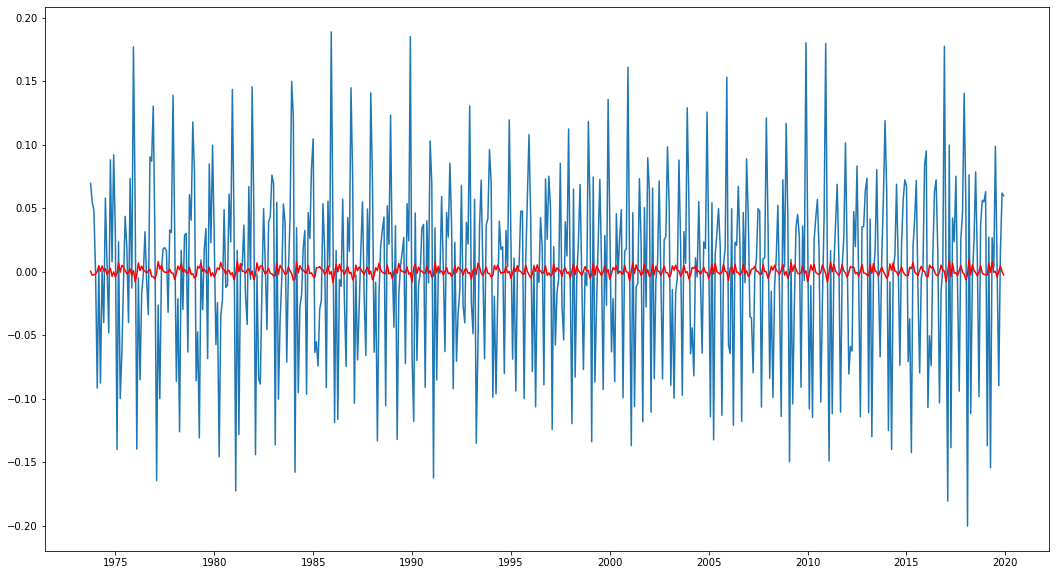

In [17]:
#MA Model
model = ARIMA(new_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(new_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-new_log_diff)**2))

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

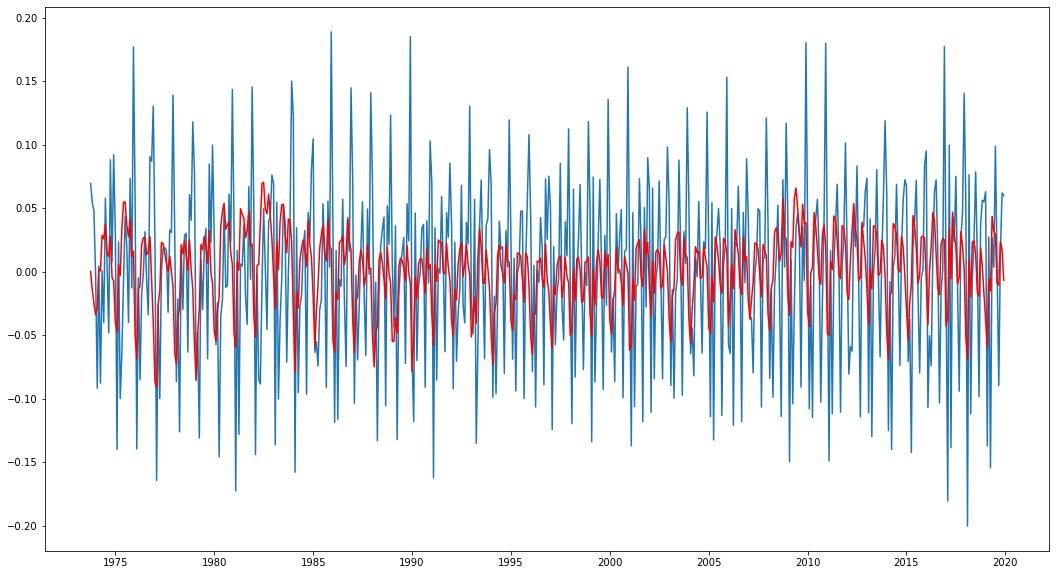

In [18]:
#Combined model
model = ARIMA(new_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(new_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-new_log_diff)**2))

In [19]:
#Splitting datasets into training and test datasets
cons_ts=new_df
cons_train = cons_ts[:472]
cons_test = cons_ts[-84:]

In [20]:
#Finding best ARIMA (p,d,q) parameters
cons_arima_model =  auto_arima(cons_train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6314.605, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6207.670, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6059.301, Time=0.53 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=6234.755, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=6058.485, Time=0.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=6161.081, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=6055.272, Time=1.59 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=6114.844, Time=0.57 sec
 ARIMA(0,1,1)(3,1,1)[12]             : AIC=6055.850, Time=5.95 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=3.45 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=6090.036, Time=1.33 sec
 ARIMA(0,1,1)(3,1,2)[12]             : AIC=inf, Time=10.66 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=6108.664, Time=1.42 sec
 ARIMA(1,1,1)(2,1,1)[12]         

In [37]:
import statsmodels.api as sm
y=new_df["Consumption"]
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 2),
                                seasonal_order=(2, 1, 1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4390      0.040    -11.087      0.000      -0.517      -0.361
ma.L2         -0.2172      0.040     -5.465      0.000      -0.295      -0.139
ar.S.L12       0.0571      0.051      1.119      0.263      -0.043       0.157
ar.S.L24      -0.1365      0.043     -3.202      0.001      -0.220      -0.053
ma.S.L12      -0.7925      0.040    -19.625      0.000      -0.872      -0.713
sigma2       2.95e+04   1771.886     16.651      0.000     2.6e+04     3.3e+04


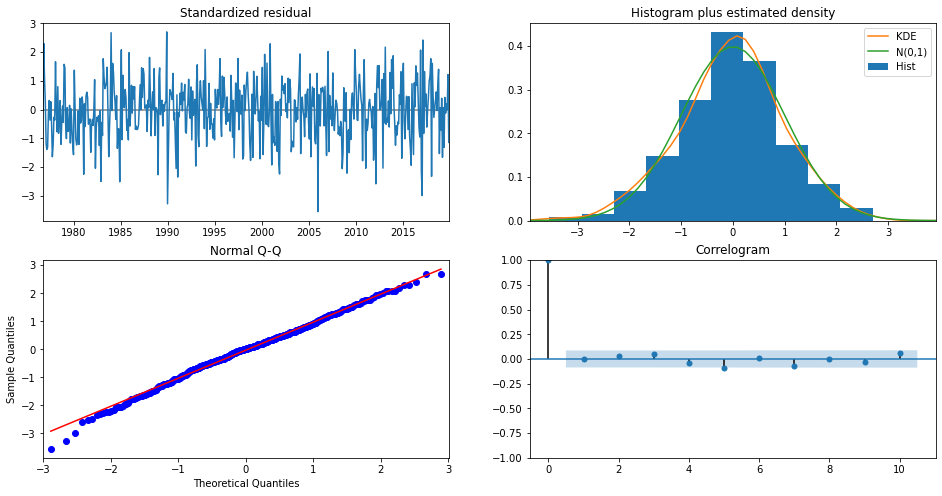

In [38]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [21]:
cons_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  472
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -3009.060
Date:                              Fri, 20 Nov 2020   AIC                           6030.121
Time:                                      21:48:54   BIC                           6054.895
Sample:                                           0   HQIC                          6039.877
                                              - 472                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3757      0.043     -8.746      0.000      -0.460      -0.292
ma.L2         -0.2751      0.044     -6.248      0.000      -0.361      -0.189
ar.S.L12       0.0580      0.060      0.962      0.336      -0.060       0.176
ar.S.L24      -0.1070      0.058     -1.843      0.065      -0.221       0.007
ma.S.L12      -0.8057      0.048    -16.805      0.000      -0.900      -0.712
sigma2      2.802e+04   1712.877     16.359      0.000    2.47e+04    3.14e+04
===================================================================================
Ljung-Box (Q):                       52.76   Jarque-Bera (JB):                 9.04
Prob(Q):                              0.09   Prob(JB):                         0.01
Heteroskedasticity (H):               1.11   Skew:                            -0.21
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

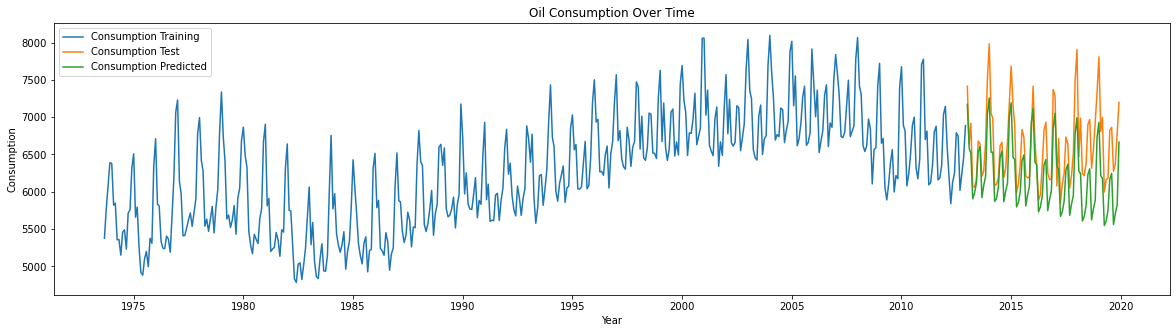

In [42]:
cons_prediction = pd.DataFrame(cons_arima_model.predict(n_periods = 84),index=cons_test.index)
cons_prediction.columns = ['cons_predicted']
plt.figure(figsize=(20,5))
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.plot(cons_train,label="Consumption Training")
plt.plot(cons_test,label="Consumption Test")
plt.plot(cons_prediction,label="Consumption Predicted")
plt.title('Oil Consumption Over Time')
plt.legend(loc = 'Left corner')
plt.show()


In [22]:
from statsmodels.tsa.arima_model import ARIMA
#series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
X = cons_ts.values
X = X.astype('float32')
size = len(X) - 1
train, test =  cons_ts[:472]
cons_test = cons_ts[-84:]
model = ARIMA(train, order=(2,1,1))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Prediction Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))


Expected: 7414.000
Forecast: 6834.177
Standard Error: 395.517
95% Prediction Interval: 6058.978 to 7609.377


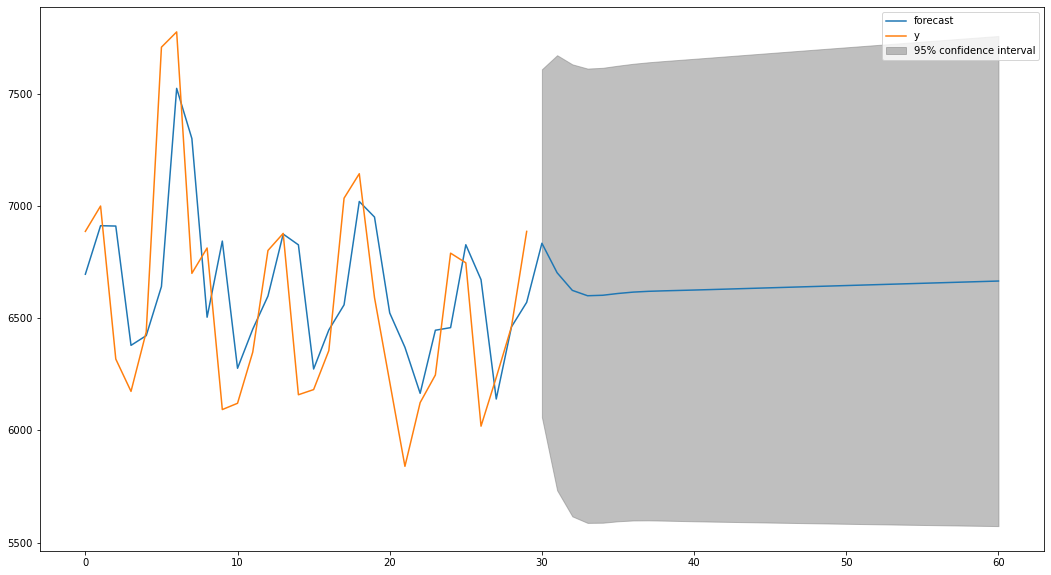

In [25]:
#Prediction fo the last month and the 1 month ahead
model_fit.plot_predict(len(train)-30, len(train)+30)
plt.show()


## Step 4c) Compare the predicted oil consumption from the ARIMA models against the observed values from our test datasets to test the accuracy of our models

In [44]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
cons_accuracy = metrics.r2_score(cons_test, cons_prediction)
cons_ARIMA_MSE = metrics.mean_squared_error(cons_test, cons_prediction)
print('MSE: %.3f' % cons_ARIMA_MSE)
print('Accuracy/Root Mean Square Error: %.3f' % cons_accuracy)

MSE: 225719.007
Accuracy/Root Mean Square Error: 0.102


## Forecast 1 year into the future (December, 2021)

In [47]:
index_1_year=cons_test.index
index_1_year = pd.date_range('2014-12-01', '2021-12-01', freq='M')


In [48]:
cons_prediction_1year = pd.DataFrame(cons_arima_model.predict(n_periods = 72),index=index_1_year)
cons_prediction_1year.columns = ['cons_prediction_1year']

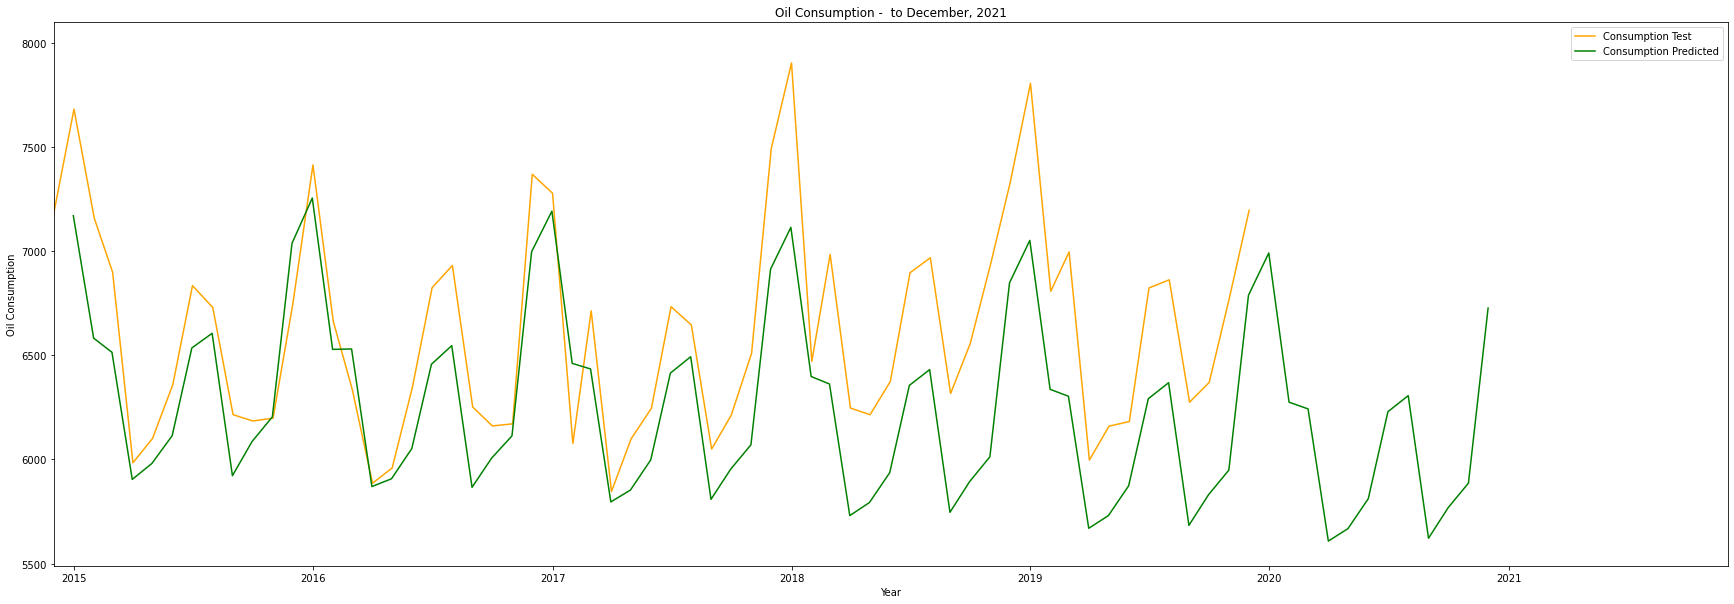

In [49]:
plt.figure(figsize=(30,10))
plt.xlabel('Year')
plt.ylabel('Oil Consumption')
plt.plot(cons_test,label="Consumption Test",c='Orange')
plt.plot(cons_prediction_1year,label="Consumption Predicted",c='Green')
plt.title('Oil Consumption -  to December, 2021')
plt.legend(loc = 'Left corner')
plt.xlim('2014-12-01','2021-12-01')
plt.show()
